 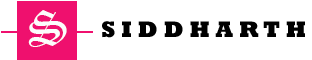

#**Private Script**

In [ ]:
#@title Start GUI Colab
import apt, apt.debfile
import pathlib, stat, shutil, urllib.request, subprocess, getpass, time, tempfile
import secrets, json, re
import IPython.utils.io
import ipywidgets
import os
from IPython.display import clear_output

class _NoteProgress(apt.progress.base.InstallProgress, apt.progress.base.AcquireProgress, apt.progress.base.OpProgress):
  def __init__(self):
    apt.progress.base.InstallProgress.__init__(self)
    self._label = ipywidgets.Label()
    display(self._label)
    self._float_progress = ipywidgets.FloatProgress(min = 0.0, max = 1.0, layout = {'border':'1px solid #118800'})
    display(self._float_progress)

  def close(self):
    self._float_progress.close()
    self._label.close()

  def fetch(self, item):
    self._label.value = "fetch: " + item.shortdesc

  def pulse(self, owner):
    self._float_progress.value = self.current_items / self.total_items
    return True

  def status_change(self, pkg, percent, status):
    self._label.value = "%s: %s" % (pkg, status)
    self._float_progress.value = percent / 100.0

  def update(self, percent=None):
    self._float_progress.value = self.percent / 100.0
    self._label.value = self.op + ": " + self.subop

  def done(self, item=None):
    pass

class _MyApt:
  def __init__(self):
    self._progress = _NoteProgress()
    self._cache = apt.Cache(self._progress)

  def close(self):
    self._cache.close()
    self._cache = None
    self._progress.close()
    self._progress = None

  def update_upgrade(self):
    self._cache.update()
    self._cache.open(None)
    self._cache.upgrade()

  def commit(self):
    self._cache.commit(self._progress, self._progress)
    self._cache.clear()

  def installPkg(self, *args):
    for name in args:
      pkg = self._cache[name]
      if pkg.is_installed:
        print(f"{name} is already installed")
      else:
        pkg.mark_install()

  def installDebPackage(self, name):
    apt.debfile.DebPackage(name, self._cache).install()

  def deleteInstalledPkg(self, *args):
    for pkg in self._cache:
      if pkg.is_installed:
        for name in args:
          if pkg.name.startswith(name):
            #print(f"Delete {pkg.name}")
            pkg.mark_delete()

def _download(url, path):
  try:
    with urllib.request.urlopen(url) as response:
      with open(path, 'wb') as outfile:
        shutil.copyfileobj(response, outfile)
  except:
    print("Failed to download ", url)
    raise

def _get_gpu_name():
  r = subprocess.run(["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"], stdout = subprocess.PIPE, universal_newlines = True)
  if r.returncode != 0:
    return None
  return r.stdout.strip()

def _check_gpu_available():
  gpu_name = _get_gpu_name()
  if gpu_name == None:
    print("This is not a runtime with GPU")
  else:
    return True

  return True

def _setupSSHDImpl(ngrok_token, ngrok_region, is_VNC):

  msg = ""

  if not os.path.exists('ngrok.zip'):
    _download("https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip", "ngrok.zip")
    shutil.unpack_archive("ngrok.zip")
    pathlib.Path("ngrok").chmod(stat.S_IXUSR)

  root_password = "12345678"
  user_password = "12345678"
  user_name = "colab"
  msg += "✂️"*24 + "\n"
  msg += f"root password: {root_password}\n"
  msg += f"{user_name} password: {user_password}\n"
  msg += "✂️"*24 + "\n"
  subprocess.run(["useradd", "-s", "/bin/bash", "-m", user_name])
  subprocess.run(["adduser", user_name, "sudo"], check = True)
  subprocess.run(["chpasswd"], input = f"root:{root_password}", universal_newlines = True)
  subprocess.run(["chpasswd"], input = f"{user_name}:{user_password}", universal_newlines = True)

  if not pathlib.Path('/root/.ngrok2/ngrok.yml').exists():
    subprocess.run(["./ngrok", "authtoken", ngrok_token])
  
  ngrok_proc = subprocess.Popen(["./ngrok", "tcp", "-region", ngrok_region, "5901"])
  time.sleep(2)

  with urllib.request.urlopen("http://localhost:4040/api/tunnels") as response:
    url = json.load(response)['tunnels'][0]['public_url']
    m = re.match("tcp://(.+):(\d+)", url)

  hostname = m.group(1)
  port = m.group(2)

  if is_VNC:
    msg += "Ready to Connect TurboVNC viewer:\n"
    msg += f"{hostname}:{port}\n"
  return msg

def _setupSSHDMain(ngrok_region, check_gpu_available, is_VNC):
  if check_gpu_available and not _check_gpu_available():
    return (False, "")

  gpu_name = _get_gpu_name()
  if gpu_name == None:
    print("------------------------------")

  print("Copy&paste your tunnel authtoken from https://dashboard.ngrok.com/auth")
  print("(You need to sign up for ngrok and login,)")
  #Set your ngrok Authtoken.
  ngrok_token = getpass.getpass()
  clear_output()

  if not ngrok_region:
    print("Select your ngrok region :")
    print("us - United States (Ohio)")
    print("eu - Europe (Frankfurt)")
    print("ap - Asia/Pacific (Singapore)")
    print("au - Australia (Sydney)")
    print("sa - South America (Sao Paulo)")
    print("jp - Japan (Tokyo)")
    print("in - India (Mumbai)")
    ngrok_region = region = input()
    clear_output()
    apps()

  return (True, _setupSSHDImpl(ngrok_token, ngrok_region, is_VNC))

def _setup_nvidia_gl():
  ret = subprocess.run(
                  ["nvidia-smi", "--query-gpu=driver_version", "--format=csv,noheader"],
                  stdout = subprocess.PIPE,
                  check = True,
                  universal_newlines = True)
  nvidia_version = ret.stdout.strip()
  nvidia_url = "https://us.download.nvidia.com/tesla/{0}/NVIDIA-Linux-x86_64-{0}.run".format(nvidia_version)
  _download(nvidia_url, "nvidia.run")
  pathlib.Path("nvidia.run").chmod(stat.S_IXUSR)
  subprocess.run(["./nvidia.run", "--no-kernel-module", "--ui=none"], input = "1\n", check = True, universal_newlines = True)

  #https://virtualgl.org/Documentation/HeadlessNV
  subprocess.run(["nvidia-xconfig",
                  "-a",
                  "--allow-empty-initial-configuration",
                  "--virtual=1920x1200",
                  "--busid", "PCI:0:4:0"],
                 check = True
                )

  with open("/etc/X11/xorg.conf", "r") as f:
    conf = f.read()
    conf = re.sub('(Section "Device".*?)(EndSection)',
                  '\\1    MatchSeat      "seat-1"\n\\2',
                  conf,
                  1,
                  re.DOTALL)

  with open("/etc/X11/xorg.conf", "w") as f:
    f.write(conf)

  subprocess.run(["/opt/VirtualGL/bin/vglserver_config", "-config", "+s", "+f"], check = True)
  subprocess.Popen(["Xorg", "-seat", "seat-1", "-allowMouseOpenFail", "-novtswitch", "-nolisten", "tcp"])

def _setupVNC():
  libjpeg_ver = "2.0.5"
  virtualGL_ver = "2.6.4"
  turboVNC_ver = "2.2.5"

  libjpeg_url = "https://github.com/demotomohiro/turbovnc/releases/download/2.2.5/libjpeg-turbo-official_{0}_amd64.deb".format(libjpeg_ver)
  virtualGL_url = "https://github.com/demotomohiro/turbovnc/releases/download/2.2.5/virtualgl_{0}_amd64.deb".format(virtualGL_ver)
  turboVNC_url = "https://github.com/demotomohiro/turbovnc/releases/download/2.2.5/turbovnc_{0}_amd64.deb".format(turboVNC_ver)

  _download(libjpeg_url, "libjpeg-turbo.deb")
  _download(virtualGL_url, "virtualgl.deb")
  _download(turboVNC_url, "turbovnc.deb")
  my_apt = _MyApt()
  my_apt.installDebPackage("libjpeg-turbo.deb")
  my_apt.installDebPackage("virtualgl.deb")
  my_apt.installDebPackage("turbovnc.deb")

  my_apt.commit()
  my_apt.close()

  vnc_sec_conf_p = pathlib.Path("/etc/turbovncserver-security.conf")
  vnc_sec_conf_p.write_text("""\
no-remote-connections
no-httpd
no-x11-tcp-connections
""")

  gpu_name = _get_gpu_name()
  if gpu_name != None:
    _setup_nvidia_gl()

  vncrun_py = tempfile.gettempdir() / pathlib.Path("vncrun.py")
  vncrun_py.write_text("""\
import subprocess, secrets, pathlib

vnc_passwd = "12345678"[:8]
vnc_viewonly_passwd = "87654321"[:8]
print("✂️"*24)
print("VNC password: {}".format(vnc_passwd))
print("VNC view only password: {}".format(vnc_viewonly_passwd))
print("✂️"*24)
vncpasswd_input = "{0}\\n{1}".format(vnc_passwd, vnc_viewonly_passwd)
vnc_user_dir = pathlib.Path.home().joinpath(".vnc")
vnc_user_dir.mkdir(exist_ok=True)
vnc_user_passwd = vnc_user_dir.joinpath("passwd")
with vnc_user_passwd.open('wb') as f:
  subprocess.run(
    ["/opt/TurboVNC/bin/vncpasswd", "-f"],
    stdout=f,
    input=vncpasswd_input,
    universal_newlines=True)
vnc_user_passwd.chmod(0o600)
subprocess.run(
  ["/opt/TurboVNC/bin/vncserver"],
  cwd = pathlib.Path.home()
)

#Disable screensaver because no one would want it.
(pathlib.Path.home() / ".xscreensaver").write_text("mode: off\\n")
""")
  r = subprocess.run(
                    ["su", "-c", "python3 " + str(vncrun_py), "colab"],
                    check = True,
                    stdout = subprocess.PIPE,
                    universal_newlines = True)
  return r.stdout

def setupVNC(ngrok_region = None, check_gpu_available = True):
  stat, msg = _setupSSHDMain(ngrok_region, check_gpu_available, True)
  if stat:
    msg += _setupVNC()
  clear_output()
  _check_gpu_available()
  print(msg)

def apps():
  !sudo add-apt-repository ppa:obsproject/obs-studio -y
  clear_output()
  my_apt = _MyApt()
  my_apt.installPkg("obs-studio", "vlc", "firefox", "xarchiver", "xfce4", "xfce4-goodies")
  my_apt.commit()
  clear_output()

setupVNC()